<a href="https://colab.research.google.com/github/fedhere/MLTSA_FBianco/blob/master/CodeExamples/FittingLineToGRBAfterglows_AICBIC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fitting a line to GRB afterglow photometry

This exercise teaches you to fit the simplest model to data: a line, using different methods. 

Notes: 

    a line is a power law in log-log space. The GRB afterglow is generated by a powerlaw process
    
    we will learn later that a broken powerlaw is a prefer model for the GRB afterglow. But this exercise is about fitting lines: Linear Regression
    

# initial imports

In [1]:
import pandas as pd
import pylab as pl
import scipy
from scipy.optimize import minimize
%pylab inline

# I have created a stylesheet to define default plot behaviors. 
# This stylesheet changes the default parameters stored in the dictionary matplitlib.rcParams
pl.style.use("https://raw.githubusercontent.com/fedhere/MLTSA_FBianco/master/fbb.mplstyle")
pl.rcParams['font.size'] = 20

Populating the interactive namespace from numpy and matplotlib


# Read in the input dataset
I am reading the data with Pandas. Pandas has excellent utilities for input-output of tabular data and also for time variables. We will use it throughout as our main package to acquire and manipulate data

In [2]:
grbAG = pd.read_csv("https://raw.githubusercontent.com/fedhere/MLTSA_FBianco/master/HW1/grb050525A.csv")
grbAG.head()

,filter,time,mag,magerr,upperlimit
0,V,66,13.21,0.24,0
1,V,67,12.90,0.23,0
2,V,68,12.86,0.23,0
3,V,69,13.01,0.23,0
4,V,70,12.97,0.23,0


In [3]:
grbAG.time

0           66
1           67
2           68
3           69
4           70
        ...   
114      63738
115      74798
116     128928
117     971360
118    1171176
Name: time, Length: 119, dtype: int64

# Create the log-time variable

We will fit a line in log space. That corresponds to fitting a powerlaw y=x^a in natural space.


In [4]:
grbAG["logtime"] = np.log10(grbAG.time)
grbAG.head()

,filter,time,mag,magerr,upperlimit,logtime
0,V,66,13.21,0.24,0,1.819544
1,V,67,12.90,0.23,0,1.826075
2,V,68,12.86,0.23,0,1.832509
3,V,69,13.01,0.23,0,1.838849
4,V,70,12.97,0.23,0,1.845098


# Visualize the data
The data are photometric measurements: measurement of flux from an exploding star. The flux is measured in different photometric bands, i.e. within different wavelength range. You can think about this as a filter that would limit the light collected by a camera to a single color, e.g. red, blue, or green. In most all cameras (your phone camera for example) collect data in RGB bands saparately and combine them to create a "color picture". Our eyes also perceive color in 3 bands, R, G, B. 

The information about the photometric band is stored in the variable ```grbAG.filter```. Plot the data with different colors for different photometric bands.

findfont: Font family ['["sans-serif"]'] not found. Falling back to DejaVu Sans.


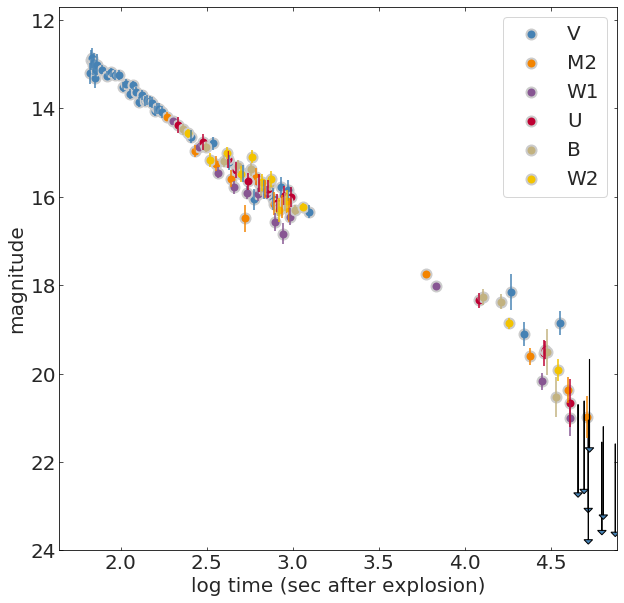

In [5]:
#create a figure container and an axis object inside of it
ax = pl.figure(figsize=(10,10)).add_subplot(111)
    
#loop on every filter to plot - this will give differnt colors naturally. 
#Use pl.errorbar to plot the uncertainties

for f in grbAG["filter"].unique():
    pl.errorbar(grbAG.loc[grbAG["filter"] == f, "logtime"], 
                grbAG.loc[grbAG["filter"] == f, "mag"], 
                yerr=grbAG.loc[grbAG["filter"] == f, "magerr"], fmt='.', ms=0,
                fcolor=None, label=None)
    
# replot to add a better marker (optional)
for f in grbAG["filter"].unique():
    pl.scatter(grbAG.loc[grbAG["filter"] == f, "logtime"], 
               grbAG.loc[grbAG["filter"] == f, "mag"], 
               alpha=1, s=100, linewidth=2,
               label=f,
               edgecolor='#cccccc')
    

# plot the upperlimits as arrows
for i in grbAG[grbAG.upperlimit == 1].index:
    pl.arrow(grbAG.loc[i].logtime, 
             grbAG.loc[i].magerr, 0, 2, 
            head_width=0.05, head_length=0.1, ec='k')

# I am going to invert the y axis because the "magnitude" measurement is an inverse scale: brighter is smaller
pl.ylim(24,11.7)          
pl.legend()

#Always rememebr you axis labels!!
pl.ylabel("magnitude", fontsize=20)
pl.xlabel("log time (sec after explosion)", fontsize=20);

Figure 1: Photometry of the Afterglow of GRB 052505A. All photometry is from the Swift satellite and it is obtained from Table 3 of Blustin et al. 2005 https://arxiv.org/pdf/astro-ph/0507515.pdf. The photometric band for each datapoint is indicated in the legend. Time is relative from the estimated moment of explosion of the stellar progenitor. Upperlimits are indicated by down-pointing arrows. 

In [6]:
x = grbAG[grbAG.upperlimit == 0].logtime.values

X = np.c_[np.ones((len(grbAG) - grbAG.upperlimit.sum(), 1)),
          x]


y = grbAG.loc[grbAG.upperlimit == 0].mag.values
print("shape of the input array X", X.shape)
print("shape of the input array y", y.shape)
#note the shape in python is flipped compared to the shape in linear algebra

shape of the input array X (108, 2)
shape of the input array y (108,)



# Fit a line to the data (excluding the upper limits) by minimizing an objective function that accounts for the measurements uncertainties

Since the data has uncertainty, choose the $\chi^2$ (chi squared) function as your objective function.

In [0]:
def poly(x, pars):
    #print (pars)
    res = 0
    for i,p in enumerate(pars):
        res += p * pow(x, i)
    return res 


In [8]:
def chi2(args, x, y, s):
    #print(args)
    return sum((y - poly(x, args))**2 / s**2)

x = grbAG[grbAG.upperlimit == 0].logtime.values
y = grbAG.loc[grbAG.upperlimit == 0].mag.values
s = grbAG.loc[grbAG.upperlimit == 0].magerr.values

initialGuess = (10, 1)

chi2Solution = minimize(chi2, initialGuess, args=(x, y, s))
print(chi2Solution)
print("")
print("best fit parameters from the minimization of the chi squared: " + 
       "slope {:.2f}, intercept {:.2f}".format(*chi2Solution.x))

      fun: 317.4206698013064
 hess_inv: array([[8.44473049e-08, 6.65230410e-10],
       [6.65230410e-10, 3.32615205e-11]])
      jac: array([0.0000000e+00, 7.2479248e-05])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 193
      nit: 7
     njev: 48
   status: 2
  success: False
        x: array([8.59948747, 2.48019102])

best fit parameters from the minimization of the chi squared: slope 8.60, intercept 2.48


In [12]:
def aic(x, l, k):
  return  2 / len(x) * (l + k) 
print(aic)

def bic(x, l, k):
  return  2 * l + np.log(len(x)) * k 
print(bic)

<function aic at 0x7f86b8014158>
<function bic at 0x7f86bb170730>


Text(0.5, 0, 'number of parameters')

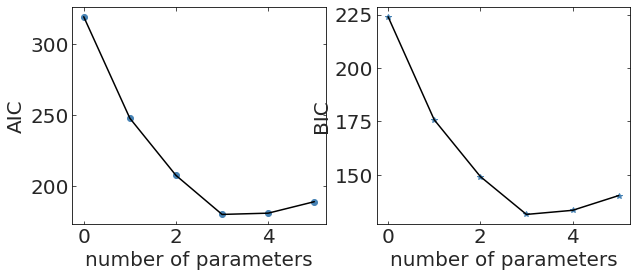

In [17]:
initialGuess = [10]
aics, bics = [], []
ls = []
for i in range(6):
  initialGuess = initialGuess + [1]

  chi2Solution = minimize(chi2, initialGuess, args=(x, y, s))
  aics.append(aic(x[::70], len(initialGuess), chi2Solution.fun))
  bics.append(bic(x[::70], len(initialGuess), chi2Solution.fun))

fig = pl.figure(figsize=(10,4))
ax1 = fig.add_subplot(121)
ax1.set_ylabel("AIC")
pl.plot(aics, 'o')
pl.plot(aics, 'k-')
ax1.set_xlabel("number of parameters")
ax2 = fig.add_subplot(122)
pl.plot(bics, '*')
pl.plot(bics, 'k-')
ax2.set_ylabel("BIC")
ax2.set_xlabel("number of parameters")